In [114]:
import os
import pandas as pd

# Define base directory and subdirectories
base_dir = "blockchain/test_data/results"
os_folders = ["Aws", "Linux", "macOS", "Windows"]
hash_names = ["blake2b", "blake2s", "blake3", "sha256", "sha512"]
rounds = [f"round{i}" for i in range(1, 10)]

# Initialize a list to store the raw data
raw_data = []

# Loop through each OS folder, hash algorithm, and round file
for os_folder in os_folders:
    for hash_name in hash_names:
        for round_name in rounds:
            file_path = os.path.join(base_dir, os_folder, hash_name, f"{round_name}.txt")
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    times = [int(line.strip()) for line in file.readlines()]  # Read nanoseconds
                    raw_data.append({
                        "OS": os_folder,
                        "Hash": hash_name,
                        "Round": round_name,
                        "RawTimes": times  # Store raw data as a list
                    })

# Convert the raw data list into a Pandas DataFrame
df = pd.DataFrame(raw_data)

# Optional: Save the raw DataFrame to a CSV file for later use
df.to_csv("blockchain_analysis/raw_data.csv", index=False)

# Display the first few rows of the DataFrame
df.head()

,OS,Hash,Round,RawTimes
0,Aws,blake2b,round1,"[44934703, 120636421, 415051906, 53520626, 516..."
1,Aws,blake2b,round2,"[7945856, 245742699, 47715514, 99645483, 13666..."
2,Aws,blake2b,round3,"[723023, 110908919, 32225624, 83264648, 137411..."
3,Aws,blake2b,round4,"[134709122, 45754969, 86216739, 42655083, 3901..."
4,Aws,blake2b,round5,"[96819434, 111706702, 35385041, 25141534, 4024..."


In [115]:
# Convert the 'RawTimes' column from string to list
df['RawTimes'] = df['RawTimes'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Expand the data by exploding the 'RawTimes' list into individual rows
df_expanded = df.explode('RawTimes')
df_expanded['RawTimes'] = pd.to_numeric(df_expanded['RawTimes'])

# Compute average times by OS, Algorithm, and Round
avg_times_by_os = df_expanded.groupby(['OS', 'Hash', 'Round'], as_index=False)['RawTimes'].mean()
avg_times_by_os.rename(columns={'RawTimes': 'AvgTime'}, inplace=True)

# Generate the ranking of algorithms for each round by OS
ranking_by_os = avg_times_by_os.copy()
ranking_by_os['Rank'] = ranking_by_os.groupby(['OS', 'Round'])['AvgTime'].rank(ascending=True)

# Compute average times across all OS by Algorithm and Round
avg_times_all_os = avg_times_by_os.groupby(['Hash', 'Round'], as_index=False)['AvgTime'].mean()

# Generate the ranking of algorithms for each round across all OS
ranking_all_os = avg_times_all_os.copy()
ranking_all_os['Rank'] = ranking_all_os.groupby('Round')['AvgTime'].rank(ascending=True)

# Display the resulting DataFrames
print("Ranking by OS:")
print(ranking_by_os.head())

print("\nRanking across all OS:")
print(ranking_all_os.head())

# Save to CSV if needed
ranking_by_os.to_csv('ranking_by_os.csv', index=False)
ranking_all_os.to_csv('ranking_all_os.csv', index=False)

Ranking by OS:
    OS     Hash   Round       AvgTime  Rank
0  Aws  blake2b  round1  9.746634e+07   3.0
1  Aws  blake2b  round2  1.391282e+08   5.0
2  Aws  blake2b  round3  8.412643e+07   3.0
3  Aws  blake2b  round4  1.268051e+08   5.0
4  Aws  blake2b  round5  6.340960e+07   1.0

Ranking across all OS:
      Hash   Round       AvgTime  Rank
0  blake2b  round1  7.054537e+07   3.0
1  blake2b  round2  8.432730e+07   5.0
2  blake2b  round3  5.920358e+07   3.0
3  blake2b  round4  6.935274e+07   4.0
4  blake2b  round5  4.288078e+07   1.0


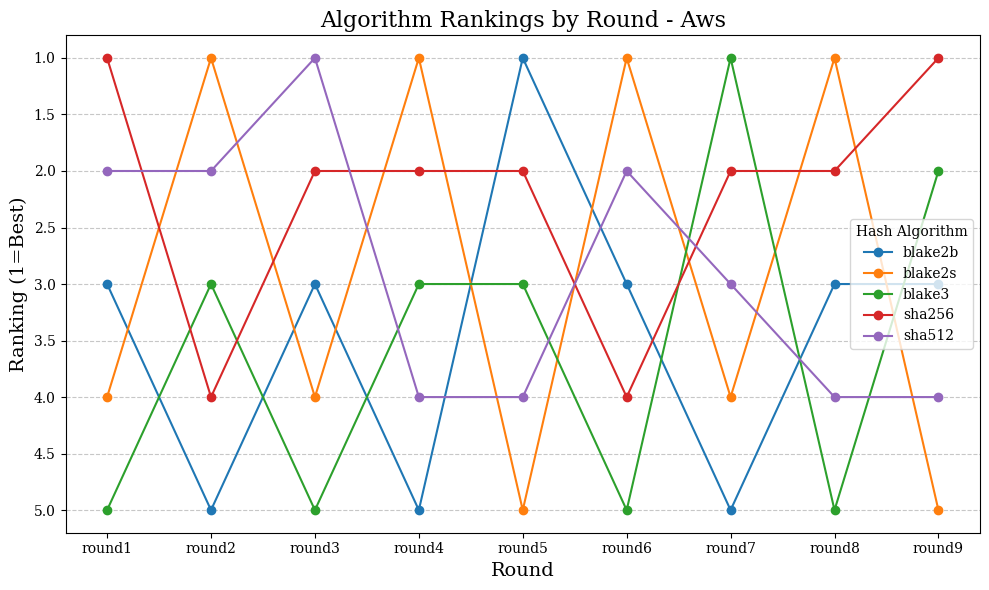

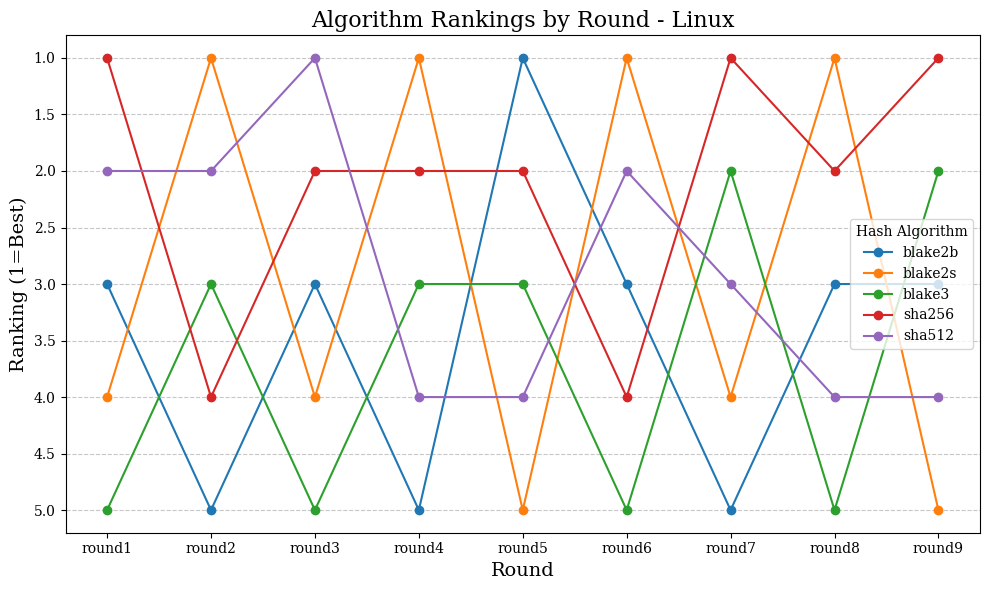

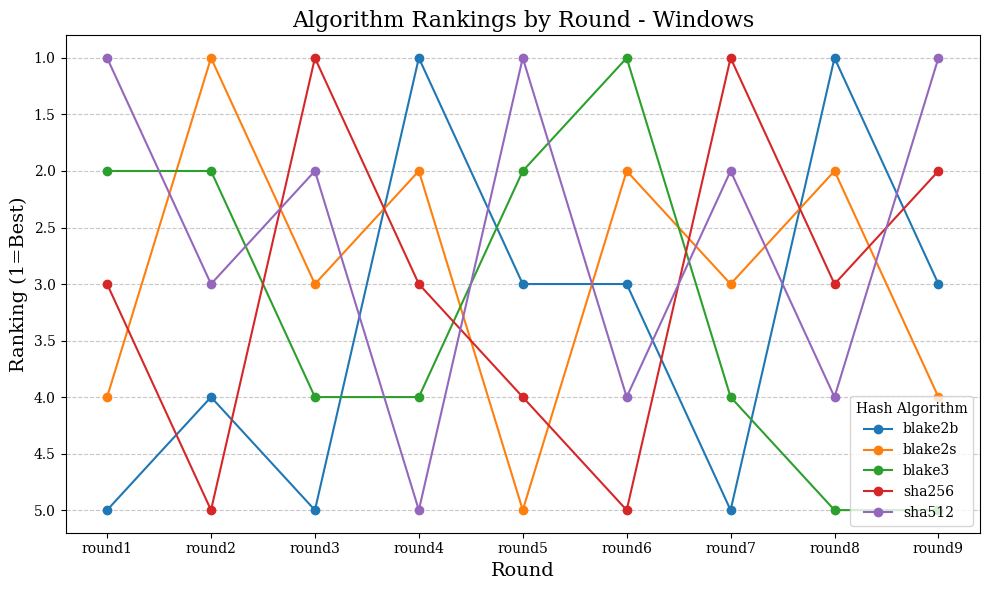

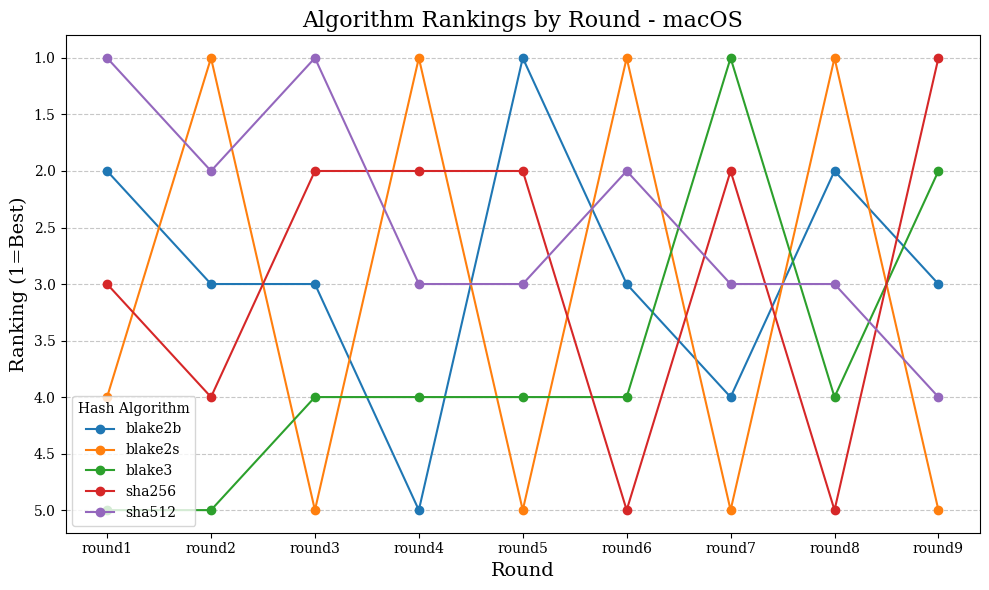

In [116]:
import matplotlib.pyplot as plt

# Plot rankings for each OS
def plot_rankings_by_os(ranking_df):
    os_list = ranking_df['OS'].unique()
    for os_name in os_list:
        os_data = ranking_df[ranking_df['OS'] == os_name]
        plt.figure(figsize=(10, 6))
        
        for hash_name in os_data['Hash'].unique():
            subset = os_data[os_data['Hash'] == hash_name]
            plt.plot(subset['Round'], subset['Rank'], marker='o', label=hash_name)
        
        plt.title(f'Algorithm Rankings by Round - {os_name}', fontsize=16)
        plt.xlabel('Round', fontsize=14)
        plt.ylabel('Ranking (1=Best)', fontsize=14)
        plt.gca().invert_yaxis()  # Invert the y-axis to show 1 as the top rank
        plt.legend(title='Hash Algorithm')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Call the plotting functions
plot_rankings_by_os(ranking_by_os)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


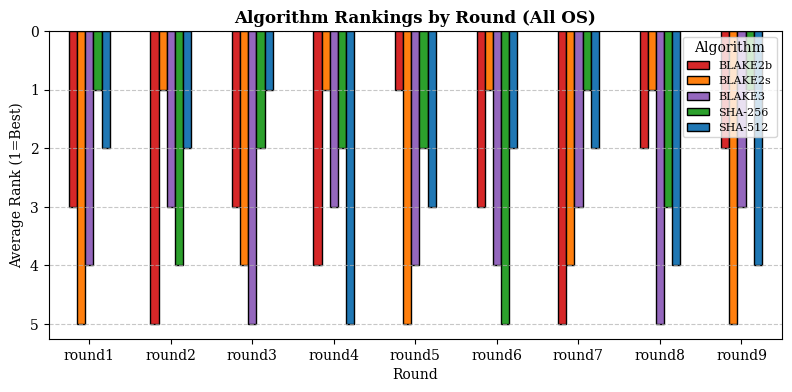

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_rankings_all_os_bar(ranking_df):
    # Rename Hash Algorithms
    algorithm_labels = {
        'blake2b': 'BLAKE2b',
        'blake2s': 'BLAKE2s',
        'blake3': 'BLAKE3',
        'sha256': 'SHA-256',
        'sha512': 'SHA-512'
    }
    ranking_df['Hash'] = ranking_df['Hash'].replace(algorithm_labels)

    # Configure font to serif
    plt.rcParams['font.family'] = 'serif'

    # Define custom colors for each algorithm
    colors = {
        'BLAKE2b': 'tab:red',
        'BLAKE2s': 'tab:orange',
        'BLAKE3': 'tab:purple',
        'SHA-256': 'tab:green',
        'SHA-512': 'tab:blue'
    }

    # Group rankings by Round and Hash
    grouped_data = ranking_df.groupby(['Round', 'Hash'], as_index=False)['Rank'].mean()

    # Pivot data for grouped bar chart
    pivot_data = grouped_data.pivot(index='Round', columns='Hash', values='Rank')

    # Plot the grouped bar chart
    color_list = [colors[algo] for algo in pivot_data.columns]
    ax = pivot_data.plot(
        kind='bar',
        figsize=(8, 4),  # Compact figure size
        color=color_list,
        edgecolor='black'
    )

    # Customize the plot
    plt.title('Algorithm Rankings by Round (All OS)', fontsize=12, fontweight='bold')
    plt.xlabel('Round', fontsize=10)
    plt.ylabel('Average Rank (1=Best)', fontsize=10)
    plt.gca().invert_yaxis()  # Invert the y-axis to show the best rank at the top
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend
    plt.legend(
        title='Algorithm', 
        fontsize=8, 
        loc='upper right'
    )

    # Adjust layout
    plt.tight_layout(pad=1.0)

    # Save the plot as EPS
    output_path = "blockchain_plots/algorithm_rankings_bar_plot.eps"
    plt.savefig(output_path, format='eps', bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function with the dataset
plot_rankings_all_os_bar(ranking_all_os)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


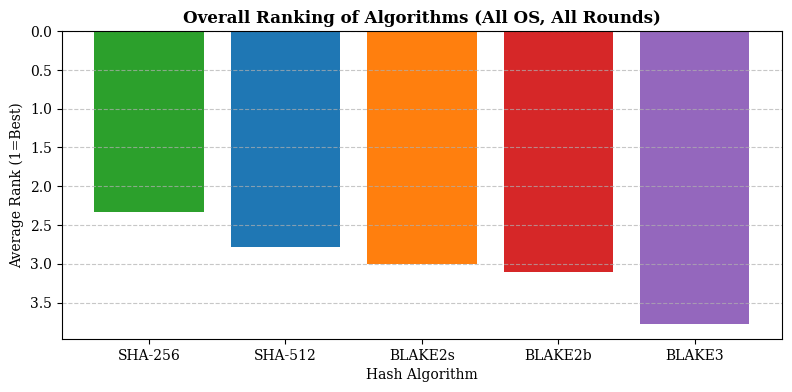

In [135]:
# Aggregate the average rank across all rounds
overall_ranking = ranking_all_os.groupby('Hash', as_index=False)['Rank'].mean()
overall_ranking.sort_values(by='Rank', inplace=True)  # Sort by rank (ascending)

# Rename Hash Algorithms
algorithm_labels = {
    'blake2b': 'BLAKE2b',
    'blake2s': 'BLAKE2s',
    'blake3': 'BLAKE3',
    'sha256': 'SHA-256',
    'sha512': 'SHA-512'
}
overall_ranking['Hash'] = overall_ranking['Hash'].replace(algorithm_labels)

# Configure font to serif
plt.rcParams['font.family'] = 'serif'

# Define custom colors for each algorithm
colors = {
    'BLAKE2b': 'tab:red',
    'BLAKE2s': 'tab:orange',
    'BLAKE3': 'tab:purple',
    'SHA-256': 'tab:green',
    'SHA-512': 'tab:blue'
}
color_list = [colors[algo] for algo in overall_ranking['Hash']]

# Plot the overall ranking
plt.figure(figsize=(8, 4))  # Compact figure size
plt.bar(
    overall_ranking['Hash'], 
    overall_ranking['Rank'], 
    color=color_list
)

# Customize the plot
plt.title('Overall Ranking of Algorithms (All OS, All Rounds)', fontsize=12, fontweight='bold')
plt.xlabel('Hash Algorithm', fontsize=10)
plt.ylabel('Average Rank (1=Best)', fontsize=10)
plt.gca().invert_yaxis()  # Invert the y-axis to show the best rank at the top
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout(pad=1.0)

# Save the plot as EPS
output_path = "blockchain_plots/overall_algorithm_ranking_plot.eps"
plt.savefig(output_path, format='eps', bbox_inches='tight')

# Show the plot
plt.show()

In [121]:
# def plot_execution_trends_by_os(avg_times_by_os):
#     os_list = avg_times_by_os['OS'].unique()
#     for os_name in os_list:
#         os_data = avg_times_by_os[avg_times_by_os['OS'] == os_name]
#         plt.figure(figsize=(12, 8))
        
#         for hash_name in os_data['Hash'].unique():
#             subset = os_data[os_data['Hash'] == hash_name]
#             plt.plot(subset['Round'], subset['AvgTime'], marker='o', label=hash_name)
        
#         plt.title(f'Execution Time Trends by OS - {os_name}', fontsize=16)
#         plt.xlabel('Round', fontsize=14)
#         plt.ylabel('Execution Time (ns)', fontsize=14)
#         plt.legend(title='Hash Algorithm')
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()

# plot_execution_trends_by_os(avg_times_by_os)

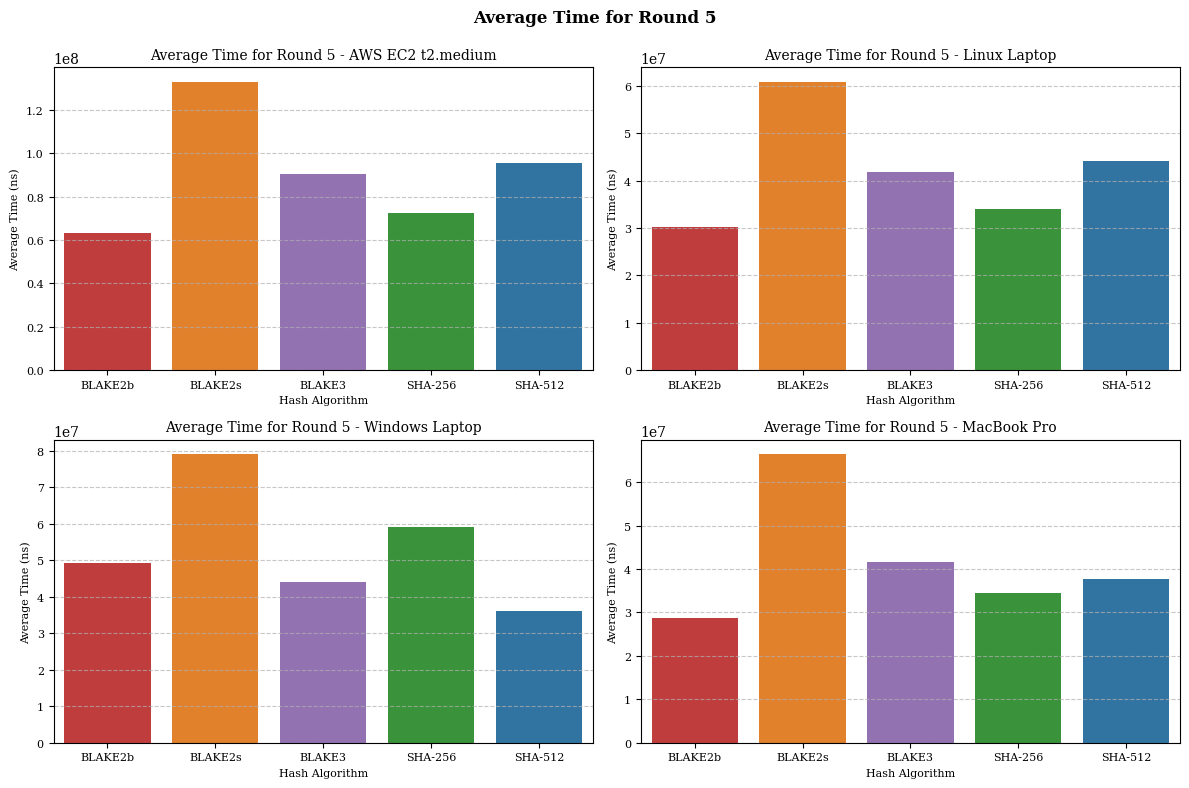

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_time_round_1(avg_times_by_os, round_of_interest):
    # OS, Hash Algorithm, and Round renaming
    os_labels = {
        'Aws': 'AWS EC2 t2.medium',
        'Windows': 'Windows Laptop',
        'Linux': 'Linux Laptop',
        'macOS': 'MacBook Pro'
    }
    
    hash_labels = {
        'blake2b': 'BLAKE2b',
        'blake2s': 'BLAKE2s',
        'blake3': 'BLAKE3',
        'sha256': 'SHA-256',
        'sha512': 'SHA-512'
    }
    
    round_labels = {f"round{i}": f"Round {i}" for i in range(1, 10)}  # Adjust range as needed
    
    # Apply renaming
    avg_times_by_os['OS'] = avg_times_by_os['OS'].replace(os_labels)
    avg_times_by_os['Hash'] = avg_times_by_os['Hash'].replace(hash_labels)
    avg_times_by_os['Round'] = avg_times_by_os['Round'].replace(round_labels)
    
    # Map the round of interest to its renamed version
    formatted_round = round_labels.get(round_of_interest, round_of_interest)
    
    # Filter the data for the specified round
    round_data = avg_times_by_os[avg_times_by_os['Round'] == formatted_round]
    
    # List of operating systems
    os_list = round_data['OS'].unique()
    
    # Custom colors for hash algorithms
    colors = {
        'BLAKE2b': 'tab:red',
        'BLAKE2s': 'tab:orange',
        'BLAKE3': 'tab:purple',
        'SHA-256': 'tab:green',
        'SHA-512': 'tab:blue'
    }
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid for 4 OSs
    axes = axes.flatten()  # Flatten for easy iteration
    
    for i, os_name in enumerate(os_list):
        ax = axes[i]
        os_data = round_data[round_data['OS'] == os_name]
        
        # Create bar chart with custom colors
        sns.barplot(
            x='Hash', 
            y='AvgTime',
            hue='Hash',
            legend=False, 
            data=os_data, 
            ax=ax, 
            palette=[colors[algo] for algo in os_data['Hash']]
        )
        
        # Subplot details
        ax.set_title(f'Average Time for {formatted_round} - {os_name}', fontsize=10)
        ax.set_xlabel('Hash Algorithm', fontsize=8)
        ax.set_ylabel('Average Time (ns)', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(
        f'Average Time for {formatted_round}', 
        fontsize=12, 
        fontweight='bold', 
        y=0.98
    )  # Global title
    plt.show()

# Call the function for Round 5
plot_avg_time_round_1(avg_times_by_os, 'round5')

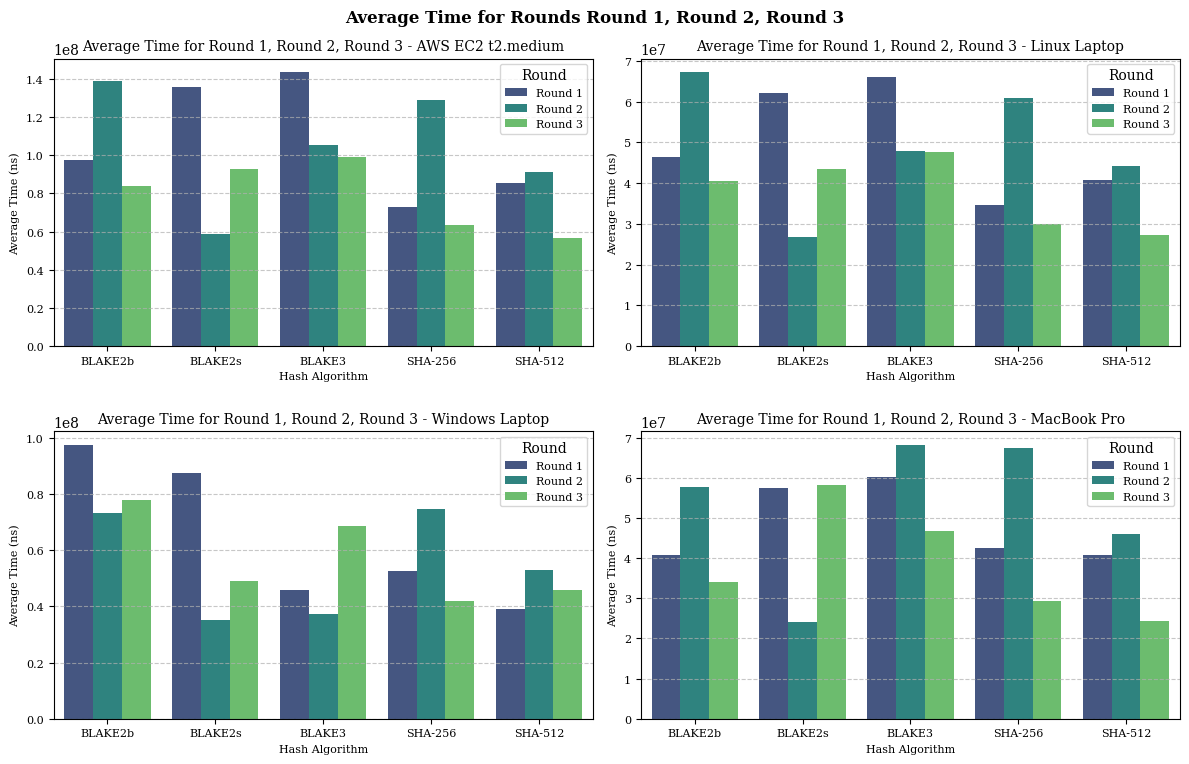

In [124]:
def plot_avg_time_multiple_rounds(avg_times_by_os, rounds_of_interest):
    # Configure font to serif
    plt.rcParams['font.family'] = 'serif'
    
    # OS and Hash Algorithm renaming
    os_labels = {
        'Aws': 'AWS EC2 t2.medium',
        'Windows': 'Windows Laptop',
        'Linux': 'Linux Laptop',
        'macOS': 'MacBook Pro'
    }
    
    hash_labels = {
        'blake2b': 'BLAKE2b',
        'blake2s': 'BLAKE2s',
        'blake3': 'BLAKE3',
        'sha256': 'SHA-256',
        'sha512': 'SHA-512'
    }
    
    # Round renaming
    round_labels = {f"round{i}": f"Round {i}" for i in range(1, 10)}  # Adjust range as needed

    # Apply renaming
    avg_times_by_os['OS'] = avg_times_by_os['OS'].replace(os_labels)
    avg_times_by_os['Hash'] = avg_times_by_os['Hash'].replace(hash_labels)
    avg_times_by_os['Round'] = avg_times_by_os['Round'].replace(round_labels)
    
    # Filter the data for the specified rounds
    formatted_rounds = [round_labels[r] for r in rounds_of_interest]
    round_data = avg_times_by_os[avg_times_by_os['Round'].isin(formatted_rounds)]
    
    # List of operating systems
    os_list = round_data['OS'].unique()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid for 4 OSs
    axes = axes.flatten()  # Flatten for easy iteration
    
    # Custom colors for rounds
    colors = sns.color_palette("viridis", len(formatted_rounds))
    
    for i, os_name in enumerate(os_list):
        ax = axes[i]
        os_data = round_data[round_data['OS'] == os_name]
        
        # Create grouped bar chart
        sns.barplot(
            x='Hash', 
            y='AvgTime', 
            hue='Round', 
            data=os_data, 
            ax=ax, 
            palette=colors
        )
        
        # Subplot details
        ax.set_title(f'Average Time for {", ".join(formatted_rounds)} - {os_name}', fontsize=10)
        ax.set_xlabel('Hash Algorithm', fontsize=8)
        ax.set_ylabel('Average Time (ns)', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.legend(title='Round', fontsize=8, loc='upper right')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(
        f'Average Time for Rounds {", ".join(formatted_rounds)}', 
        fontsize=12, 
        fontweight='bold', 
        y=0.95
    )  # Global title
    plt.show()

# Call the function for Rounds 1, 2, and 3
plot_avg_time_multiple_rounds(avg_times_by_os, ['round1', 'round2', 'round3'])